In [1]:
!pip install ultralytics contextily

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 25.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.3/22.3 MB 34.0 MB/s eta 0:00:00


In [ ]:
# === Colab: Batch shift equirectangular panoramas by N degrees (default 180) ===
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# --- Paths & settings ---
IN_DIR   = "/content/drive/MyDrive/Colab/360detection/images"
OUT_DIR  = "/content/drive/MyDrive/Colab/360detection/images_shift"
DEGREES  = 200.0  # change if you want a different yaw shift
RECURSIVE = False # set True to process subfolders too
OVERWRITE = False # set True to recompute even if output exists

# --- Imports ---
import os
from pathlib import Path
import numpy as np
from PIL import Image, ImageFile
from tqdm.auto import tqdm

ImageFile.LOAD_TRUNCATED_IMAGES = True
os.makedirs(OUT_DIR, exist_ok=True)

# --- Helper: circular yaw shift ---
def shift_equirect(img: Image.Image, degrees: float = 180.0) -> Image.Image:
    """
    Circularly shift an equirectangular image horizontally by `degrees`.
    Positive degrees -> shift content to the RIGHT (wraps around).
    """
    arr = np.array(img)             # supports L, RGB, RGBA, etc.
    h, w = arr.shape[0], arr.shape[1]
    px_shift = int(round((degrees / 360.0) * w)) % w
    if px_shift == 0:
        return img.copy()
    shifted = np.roll(arr, shift=px_shift, axis=1)
    return Image.fromarray(shifted)

# --- Collect input files ---
IN_PATH = Path(IN_DIR)
patterns = ["*.jpg", "*.jpeg", "*.png", "*.tif", "*.tiff", "*.bmp", "*.webp"]
files = []
if RECURSIVE:
    for pat in patterns:
        files.extend(IN_PATH.rglob(pat))
else:
    for pat in patterns:
        files.extend(IN_PATH.glob(pat))
files = sorted(files)

if not files:
    print(f"No images found under {IN_DIR}")
else:
    print(f"Found {len(files)} image(s). Processing…")

# --- Process ---
skipped, done, failed = 0, 0, 0
for f in tqdm(files):
    try:
        out_name = f"{f.stem}_yaw{int(DEGREES)}{f.suffix}"
        out_path = Path(OUT_DIR) / out_name

        if out_path.exists() and not OVERWRITE:
            skipped += 1
            continue

        with Image.open(f) as img:
            exif_bytes = img.info.get("exif", None)
            w, h = img.size
            if not (1.8 <= (w / h) <= 2.2):
                # Not strictly necessary for correctness; equirectangulars are usually ~2:1
                pass

            out_img = shift_equirect(img, degrees=DEGREES)

            save_kwargs = {}
            if exif_bytes and out_path.suffix.lower() in (".jpg", ".jpeg"):
                save_kwargs["exif"] = exif_bytes

            out_img.save(out_path, **save_kwargs)
            done += 1
    except Exception as e:
        failed += 1
        print(f"[ERROR] {f}: {e}")

print(f"\nCompleted. Saved: {done}, Skipped: {skipped}, Failed: {failed}")
print(f"Output folder: {OUT_DIR}")

Mounted at /content/drive
Found 36 image(s). Processing…


  0%|          | 0/36 [00:00<?, ?it/s]


Completed. Saved: 36, Skipped: 0, Failed: 0
Output folder: /content/drive/MyDrive/Colab/360detection/images_shift


In [ ]:
# # @title Batch tiled 360° detection → ground (x,y) + Folium heat map on Carto
# # Creates per-image outputs, all_people_xy.csv, and output/people_heatmap.html

# !pip -q install folium pyproj >/dev/null

# import math, os, glob, cv2, numpy as np, pandas as pd, matplotlib.pyplot as plt
# from ultralytics import YOLO
# from google.colab import drive
# import folium
# from folium.plugins import HeatMap
# from pyproj import Geod

# # ========= Paths =========
# IMAGES_DIR = "/content/drive/MyDrive/Colab/360detection/images_shift"   # input folder
# OUTPUT_DIR = "/content/drive/MyDrive/Colab/360detection/output"   # output folder

# # ========= Camera georeference (given) =========
# CAM_LAT = 35.169237383755025
# CAM_LON = 136.90874779113642
# # Orientation: horizontal center of the 360° image faces **North**
# # Our local frame already uses: +x = forward (north), +y = left (west).
# # So: East = -y, North = +x.  (No extra rotation needed.)

# # ========= Detection & projection settings =========
# MODEL_NAME   = "yolov8s.pt"   # 'yolov8m.pt' or 'yolov8x.pt' for more recall (slower)
# CAMERA_HEIGHT_M = 2.2
# PITCH_DEG    = 0.0            # if horizon isn't centered: + tilts up, - tilts down
# CONF_THRES   = 0.20
# IOU_THRES    = 0.50
# MAX_RANGE_M  = 80.0           # drop near-horizon huge ranges; None to disable

# # --- Tiling (overlapping) ---
# TILE_W = 1280
# TILE_H =  960
# OVERLAP = 0.30
# IMGSZ   = 1280
# MIN_BOX_H_PX = 40

# # --- Heat map config ---
# BIN_SIZE_M = 0.5              # still used for per-image plan-view scatter sizing
# HEAT_RADIUS_PX = 12           # folium HeatMap point radius (pixels)
# HEAT_BLUR_PX   = 18           # folium HeatMap blur (pixels)
# HEAT_MIN_OPACITY = 0.25

# # ========= Mount & prepare =========
# drive.mount('/content/drive', force_remount=False)
# assert os.path.isdir(IMAGES_DIR), f"Images folder not found: {IMAGES_DIR}"
# os.makedirs(OUTPUT_DIR, exist_ok=True)

# # Collect images
# exts = ("*.jpg","*.jpeg","*.png","*.JPG","*.JPEG","*.PNG","*.bmp","*.webp")
# img_paths = []
# for e in exts:
#     img_paths.extend(glob.glob(os.path.join(IMAGES_DIR, e)))
# img_paths = sorted(img_paths)
# print(f"Found {len(img_paths)} images.")

# # ========= Model (load once) =========
# model = YOLO(MODEL_NAME)

# # ========= Helpers =========
# def pixel_to_ground(u, v, W, H, cam_h=2.0, pitch_deg=0.0, eps=1e-9):
#     lam = 2.0 * math.pi * (u / W - 0.5)                         # [-π, π)
#     phi = (math.pi/2.0 - math.pi * (v / H)) + math.radians(pitch_deg)
#     cphi, sphi = math.cos(phi), math.sin(phi)
#     clam, slam = math.cos(lam), math.sin(lam)
#     dx = cphi * clam
#     dy = sphi
#     dz = cphi * slam
#     if dy >= -eps:
#         return None
#     t = -cam_h / dy
#     X = t * dx
#     Y = t * dz
#     rng = math.hypot(X, Y)
#     return X, Y, lam, phi, t, rng

# def nms_merge(boxes, scores, iou_thr=0.55):
#     if len(boxes) == 0:
#         return []
#     boxes = np.asarray(boxes, dtype=np.float32)
#     scores = np.asarray(scores, dtype=np.float32)
#     idxs = scores.argsort()[::-1]
#     keep = []
#     while idxs.size > 0:
#         i = idxs[0]
#         keep.append(i)
#         if idxs.size == 1:
#             break
#         xx1 = np.maximum(boxes[i,0], boxes[idxs[1:],0])
#         yy1 = np.maximum(boxes[i,1], boxes[idxs[1:],1])
#         xx2 = np.minimum(boxes[i,2], boxes[idxs[1:],2])
#         yy2 = np.minimum(boxes[i,3], boxes[idxs[1:],3])
#         w = np.maximum(0, xx2 - xx1)
#         h = np.maximum(0, yy2 - yy1)
#         inter = w * h
#         area_i = (boxes[i,2]-boxes[i,0])*(boxes[i,3]-boxes[i,1])
#         area_j = (boxes[idxs[1:],2]-boxes[idxs[1:],0])*(boxes[idxs[1:],3]-boxes[idxs[1:],1])
#         iou = inter / (area_i + area_j - inter + 1e-9)
#         idxs = idxs[1:][iou <= iou_thr]
#     return keep

# def save_topdown(df, title, out_path):
#     plt.figure(figsize=(6,6))
#     plt.axhline(0, linewidth=1); plt.axvline(0, linewidth=1)
#     plt.scatter(df["x_m"], df["y_m"], s=60)
#     for _, row in df.iterrows():
#         plt.text(row["x_m"], row["y_m"], f'{row["range_m"]:.1f}m', fontsize=9, ha="left", va="bottom")
#     plt.gca().set_aspect("equal", "box")
#     plt.title(title)
#     plt.xlabel("x [m] (forward)"); plt.ylabel("y [m] (left)")
#     plt.grid(True)
#     plt.savefig(out_path, dpi=150, bbox_inches="tight"); plt.close()

# # ========= Batch process =========
# summary_rows = []
# all_points = []  # aggregate across all images (local coords & conf)

# for IMG_PATH in img_paths:
#     img_bgr = cv2.imread(IMG_PATH)
#     if img_bgr is None:
#         print(f"⚠️ Skip (cannot read): {IMG_PATH}")
#         continue
#     H, W = img_bgr.shape[:2]
#     base = os.path.splitext(os.path.basename(IMG_PATH))[0]
#     out_dir_img = os.path.join(OUTPUT_DIR, base)
#     os.makedirs(out_dir_img, exist_ok=True)
#     print(f"\nProcessing: {base}  ({W}x{H})")

#     # --- Generate tiles ---
#     step_x = max(1, int(TILE_W * (1 - OVERLAP)))
#     step_y = max(1, int(TILE_H * (1 - OVERLAP)))
#     xs = list(range(0, max(W - TILE_W, 0) + 1, step_x))
#     ys = list(range(0, max(H - TILE_H, 0) + 1, step_y))
#     if xs[-1] != W - TILE_W: xs.append(W - TILE_W)
#     if ys[-1] != H - TILE_H: ys.append(H - TILE_H)
#     print(f"  Tiling: {len(xs)} x {len(ys)} = {len(xs)*len(ys)} tiles")

#     # --- Detect across tiles ---
#     global_boxes, global_scores = [], []
#     for y0 in ys:
#         for x0 in xs:
#             tile = img_bgr[y0:y0+TILE_H, x0:x0+TILE_W]
#             res = model.predict(
#                 source=tile[:, :, ::-1], imgsz=IMGSZ,
#                 conf=CONF_THRES, iou=IOU_THRES, classes=[0], verbose=False
#             )[0]
#             if res.boxes is None or len(res.boxes) == 0:
#                 continue
#             xyxy = res.boxes.xyxy.cpu().numpy()
#             confs = res.boxes.conf.cpu().numpy()
#             # Map to global pano coords
#             xyxy[:, [0,2]] += x0
#             xyxy[:, [1,3]] += y0
#             # Filter tiny boxes (in pano pixels)
#             h_px = xyxy[:,3] - xyxy[:,1]
#             keep = h_px >= MIN_BOX_H_PX
#             xyxy = xyxy[keep]; confs = confs[keep]
#             for b, s in zip(xyxy, confs):
#                 global_boxes.append(b.tolist())
#                 global_scores.append(float(s))

#     # --- Merge duplicates across tiles ---
#     keep_idx = nms_merge(global_boxes, global_scores, iou_thr=0.55)
#     global_boxes = [global_boxes[i] for i in keep_idx]
#     global_scores = [global_scores[i] for i in keep_idx]
#     print(f"  Detections after merge: {len(global_boxes)}")

#     # --- Project to ground ---
#     detections = []
#     for b, conf in zip(global_boxes, global_scores):
#         x1, y1, x2, y2 = b
#         u = float(np.clip((x1 + x2) * 0.5, 0, W-1))  # bottom-center
#         v = float(np.clip(y2, 0, H-1))
#         g = pixel_to_ground(u, v, W, H, cam_h=CAMERA_HEIGHT_M, pitch_deg=PITCH_DEG)
#         if g is None:
#             continue
#         X, Y, lam, phi, t, rng = g
#         if MAX_RANGE_M is not None and rng > MAX_RANGE_M:
#             continue
#         row = {
#             "image": base,
#             "x_m": X, "y_m": Y, "range_m": rng, "conf": conf,
#             "u_px": u, "v_px": v,
#             "bbox_x1": x1, "bbox_y1": y1, "bbox_x2": x2, "bbox_y2": y2,
#             "lambda_rad": lam, "phi_rad": phi, "ray_t": t
#         }
#         detections.append(row)
#         all_points.append(row)

#     # --- Per-image outputs ---
#     if detections:
#         df = pd.DataFrame(detections).sort_values("range_m")
#         csv_path = os.path.join(out_dir_img, "people_xy.csv")
#         df.to_csv(csv_path, index=False)
#         save_topdown(df, f"{base} — ground positions (x forward, y left) [m]",
#                      os.path.join(out_dir_img, "topdown_scatter.png"))

#         # Panorama preview
#         img_draw = img_bgr.copy()
#         for d in detections:
#             x1, y1, x2, y2 = map(int, [d["bbox_x1"], d["bbox_y1"], d["bbox_x2"], d["bbox_y2"]])
#             cv2.rectangle(img_draw, (x1,y1), (x2,y2), (0,255,0), 2)
#             cv2.circle(img_draw, (int(d["u_px"]), int(d["v_px"])), 5, (0,0,255), -1)
#             cv2.putText(img_draw, f'{d["range_m"]:.1f}m', (x1, max(0,y1-5)),
#                         cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0,255,0), 2, cv2.LINE_AA)
#         cv2.imwrite(os.path.join(out_dir_img, "preview_tiled.jpg"), img_draw)

#         n = len(df)
#         mean_rng = float(df["range_m"].mean())
#         max_rng = float(df["range_m"].max())
#         min_rng = float(df["range_m"].min())
#     else:
#         df = pd.DataFrame(columns=[
#             "image","x_m","y_m","range_m","conf","u_px","v_px",
#             "bbox_x1","bbox_y1","bbox_x2","bbox_y2","lambda_rad","phi_rad","ray_t"
#         ])
#         csv_path = os.path.join(out_dir_img, "people_xy.csv")
#         df.to_csv(csv_path, index=False)
#         n = 0; mean_rng = max_rng = min_rng = float("nan")

#     # --- Update summary ---
#     summary_rows.append({
#         "image": base,
#         "input_path": IMG_PATH,
#         "detections": n,
#         "mean_range_m": mean_rng,
#         "min_range_m": min_rng,
#         "max_range_m": max_rng,
#         "per_image_csv": csv_path,
#         "preview_jpg": os.path.join(out_dir_img, "preview_tiled.jpg"),
#         "topdown_png": os.path.join(out_dir_img, "topdown_scatter.png")
#     })

# # ========= Save summary & aggregate heat map (Folium) =========
# summary_df = pd.DataFrame(summary_rows)
# summary_csv = os.path.join(OUTPUT_DIR, "summary.csv")
# summary_df.to_csv(summary_csv, index=False)
# print(f"\n✅ Summary saved: {summary_csv}")

# if len(all_points) == 0:
#     print("⚠️ No detections found in any image. Heat map not created.")
# else:
#     all_df = pd.DataFrame(all_points).sort_values(["image","range_m"])
#     all_csv = os.path.join(OUTPUT_DIR, "all_people_xy.csv")
#     all_df.to_csv(all_csv, index=False)
#     print(f"✅ All detections saved: {all_csv}  ({len(all_df)} rows)")

#     # ---- Convert local (x,y) → geographic (lat, lon) using WGS84 geodesic ----
#     # Local frame → ENU: East = -y, North = +x (since +y is "left" of North).
#     east  = (-all_df["y_m"].to_numpy()).astype(float)
#     north = ( all_df["x_m"].to_numpy()).astype(float)
#     dist  = np.hypot(east, north)
#     # Bearing from North clockwise:
#     bearings = np.degrees(np.arctan2(east, north))  # [-180,180]
#     bearings[bearings < 0] += 360.0

#     geod = Geod(ellps="WGS84")
#     lons, lats = [], []
#     for brg, d in zip(bearings, dist):
#         lon2, lat2, _ = geod.fwd(CAM_LON, CAM_LAT, brg, d)
#         lons.append(lon2)
#         lats.append(lat2)

#     all_df["lat"] = lats
#     all_df["lon"] = lons

#     # Save a geo CSV too
#     geo_csv = os.path.join(OUTPUT_DIR, "all_people_geo.csv")
#     all_df.to_csv(geo_csv, index=False)
#     print(f"🌍 Geo CSV saved: {geo_csv}")

#     # ---- Build Folium map with CartoDB Positron tiles ----
#     m = folium.Map(location=[CAM_LAT, CAM_LON], zoom_start=19, tiles=None)
#     folium.TileLayer(
#         tiles="https://{s}.basemaps.cartocdn.com/light_all/{z}/{x}/{y}{r}.png",
#         attr='© OpenStreetMap contributors © CARTO',
#         name="CartoDB Positron",
#         control=True
#     ).add_to(m)

#     # Camera marker
#     folium.Marker(
#         [CAM_LAT, CAM_LON], tooltip="Camera",
#         icon=folium.Icon(color="blue", icon="camera", prefix="fa")
#     ).add_to(m)

#     # Heat map data (confidence-weighted)
#     heat_data = [[row.lat, row.lon, float(row.conf)] for row in all_df.itertuples()]
#     HeatMap(
#         heat_data,
#         radius=HEAT_RADIUS_PX,
#         blur=HEAT_BLUR_PX,
#         min_opacity=HEAT_MIN_OPACITY,
#         max_zoom=21
#     ).add_to(m)

#     folium.LayerControl().add_to(m)
#     heatmap_html = os.path.join(OUTPUT_DIR, "people_heatmap.html")
#     m.save(heatmap_html)
#     print(f"🔥 Folium heat map saved: {heatmap_html}")
#     m

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Found 35 images.

Processing: IMG_20250906_110448_00_008_yaw200  (11904x5952)
  Tiling: 13 x 9 = 117 tiles
  Detections after merge: 40

Processing: IMG_20250906_111350_00_016_yaw200  (11904x5952)
  Tiling: 13 x 9 = 117 tiles
  Detections after merge: 42

Processing: IMG_20250906_112248_00_024_yaw200  (11904x5952)
  Tiling: 13 x 9 = 117 tiles
  Detections after merge: 61

Processing: IMG_20250906_113147_00_032_yaw200  (11904x5952)
  Tiling: 13 x 9 = 117 tiles
  Detections after merge: 45

Processing: IMG_20250906_114044_00_040_yaw200  (11904x5952)
  Tili

In [ ]:
# @title Stage A: Batch tiled 360° detection (pixel-space only)
import os, glob, math, cv2, numpy as np, pandas as pd
from ultralytics import YOLO
from google.colab import drive

# ========= Paths =========
IMAGES_DIR  = "/content/drive/MyDrive/Colab/360detection/images_shift"     # input 360s
OUTPUT_DIR  = "/content/drive/MyDrive/Colab/360detection/output"     # base output
DET_DIR     = os.path.join(OUTPUT_DIR, "detections")                  # pixel-space CSVs
os.makedirs(OUTPUT_DIR, exist_ok=True)
os.makedirs(DET_DIR, exist_ok=True)

# ========= Detection settings =========
MODEL_NAME     = "yolov8s.pt"    # try yolov8m/x for more recall
CONF_THRES     = 0.20
IOU_THRES      = 0.50

# --- Tiling (overlap) ---
TILE_W, TILE_H = 1280, 960
OVERLAP        = 0.30
IMGSZ          = 1280
MIN_BOX_H_PX   = 40

# ========= Mount & list images =========
drive.mount('/content/drive', force_remount=False)
assert os.path.isdir(IMAGES_DIR), f"Images folder not found: {IMAGES_DIR}"
exts = ("*.jpg","*.jpeg","*.png","*.JPG","*.JPEG","*.PNG","*.bmp","*.webp")
img_paths = sorted([p for e in exts for p in glob.glob(os.path.join(IMAGES_DIR, e))])
print(f"Found {len(img_paths)} images.")

# ========= Helpers =========
def nms_merge(boxes, scores, iou_thr=0.55):
    if not boxes: return []
    boxes = np.asarray(boxes, dtype=np.float32)
    scores = np.asarray(scores, dtype=np.float32)
    idxs = scores.argsort()[::-1]
    keep = []
    while idxs.size:
        i = idxs[0]; keep.append(i)
        if idxs.size == 1: break
        xx1 = np.maximum(boxes[i,0], boxes[idxs[1:],0])
        yy1 = np.maximum(boxes[i,1], boxes[idxs[1:],1])
        xx2 = np.minimum(boxes[i,2], boxes[idxs[1:],2])
        yy2 = np.minimum(boxes[i,3], boxes[idxs[1:],3])
        w = np.maximum(0, xx2-xx1); h = np.maximum(0, yy2-yy1)
        inter = w*h
        area_i = (boxes[i,2]-boxes[i,0])*(boxes[i,3]-boxes[i,1])
        area_j = (boxes[idxs[1:],2]-boxes[idxs[1:],0])*(boxes[idxs[1:],3]-boxes[idxs[1:],1])
        iou = inter / (area_i + area_j - inter + 1e-9)
        idxs = idxs[1:][iou <= iou_thr]
    return keep

# ========= Run detection =========
model = YOLO(MODEL_NAME)
all_rows = []

for IMG_PATH in img_paths:
    img_bgr = cv2.imread(IMG_PATH)
    if img_bgr is None:
        print(f"⚠️ cannot read: {IMG_PATH}"); continue
    H, W = img_bgr.shape[:2]
    base = os.path.splitext(os.path.basename(IMG_PATH))[0]
    print(f"\nDetecting: {base} ({W}x{H})")

    # tile grid
    step_x = max(1, int(TILE_W*(1-OVERLAP)))
    step_y = max(1, int(TILE_H*(1-OVERLAP)))
    xs = list(range(0, max(W-TILE_W,0)+1, step_x))
    ys = list(range(0, max(H-TILE_H,0)+1, step_y))
    if xs[-1] != W-TILE_W: xs.append(W-TILE_W)
    if ys[-1] != H-TILE_H: ys.append(H-TILE_H)

    boxes_g, confs_g = [], []

    for y0 in ys:
        for x0 in xs:
            tile = img_bgr[y0:y0+TILE_H, x0:x0+TILE_W]
            r = model.predict(
                source=tile[:, :, ::-1], imgsz=IMGSZ,
                conf=CONF_THRES, iou=IOU_THRES, classes=[0], verbose=False
            )[0]
            if r.boxes is None or len(r.boxes) == 0: continue
            xyxy = r.boxes.xyxy.cpu().numpy()
            conf = r.boxes.conf.cpu().numpy()
            # map back to pano coords
            xyxy[:,[0,2]] += x0; xyxy[:,[1,3]] += y0
            # size filter
            hpx = xyxy[:,3]-xyxy[:,1]
            keep = hpx >= MIN_BOX_H_PX
            xyxy, conf = xyxy[keep], conf[keep]
            for b,s in zip(xyxy,conf):
                boxes_g.append(b.tolist()); confs_g.append(float(s))

    keep = nms_merge(boxes_g, confs_g, iou_thr=0.55)
    boxes_g = [boxes_g[i] for i in keep]
    confs_g = [confs_g[i] for i in keep]
    print(f"  merged detections: {len(boxes_g)}")

    rows = []
    for (x1,y1,x2,y2), c in zip(boxes_g, confs_g):
        u = float(np.clip((x1+x2)*0.5, 0, W-1))  # foot pixel-bottom center
        v = float(np.clip(y2, 0, H-1))
        rows.append({
            "image": base, "input_path": IMG_PATH, "W": W, "H": H,
            "bbox_x1": x1, "bbox_y1": y1, "bbox_x2": x2, "bbox_y2": y2,
            "u_px": u, "v_px": v, "conf": c
        })
    # per-image CSV
    per_csv = os.path.join(DET_DIR, f"{base}_detections.csv")
    pd.DataFrame(rows).to_csv(per_csv, index=False)
    print(f"  saved: {per_csv}")
    all_rows.extend(rows)

# aggregate CSV (pixel-space only)
agg_csv = os.path.join(DET_DIR, "detections_all.csv")
pd.DataFrame(all_rows).to_csv(agg_csv, index=False)
print(f"\n✅ Aggregate detections saved: {agg_csv}  (rows={len(all_rows)})")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Found 35 images.

Detecting: IMG_20250906_110448_00_008_yaw200 (11904x5952)
  merged detections: 40
  saved: /content/drive/MyDrive/Colab/360detection/output/detections/IMG_20250906_110448_00_008_yaw200_detections.csv

Detecting: IMG_20250906_111350_00_016_yaw200 (11904x5952)
  merged detections: 42
  saved: /content/drive/MyDrive/Colab/360detection/output/detections/IMG_20250906_111350_00_016_yaw200_detections.csv

Detecting: IMG_20250906_112248_00_024_yaw200 (11904x5952)
  merged detections: 61
  saved: /content/drive/MyDrive/Colab/360detection/output/detections/IMG_20250906_112248_00_024_yaw200_detections.csv

Detecting: IMG_20250906_113147_00_032_yaw200 (11904x5952)
  merged detections: 45
  saved: /content/drive/MyDrive/Colab/360detection/output/detections/IMG_20250906_113147_00_032_yaw200_detections.csv

Detecting: IMG_20250906_114044_00_040_yaw200 (119

In [ ]:
# @title Stage B (updated): Pixel → (x,y) ENU → geodetic, with calibration & optional DEM
!pip -q install folium pyproj rasterio >/dev/null

import os, math, numpy as np, pandas as pd, rasterio
from pyproj import CRS, Transformer, Geod
from google.colab import drive
import folium
from folium.plugins import HeatMap

# ========= Paths =========
OUTPUT_DIR  = "/content/drive/MyDrive/Colab/360detection/output"
DET_DIR     = os.path.join(OUTPUT_DIR, "detections")
DET_AGG_CSV = os.path.join(DET_DIR, "detections_all.csv")
CALIB_NPZ   = os.path.join(OUTPUT_DIR, "calibration_cam2enu.npz")

# Optional: path to a DEM raster (GeoTIFF) providing elevations in meters (MSL)
DEM_PATH    = None  # e.g., "/content/drive/MyDrive/Colab/360detection/dem.tif"

# ========= Load detections & calibration =========
drive.mount('/content/drive', force_remount=False)
assert os.path.exists(DET_AGG_CSV), f"Not found: {DET_AGG_CSV}"
det = pd.read_csv(DET_AGG_CSV)
if det.empty:
    raise RuntimeError("detections_all.csv has no rows")
assert os.path.exists(CALIB_NPZ), "Run Stage C first to create calibration_cam2enu.npz"

nz = np.load(CALIB_NPZ)
R_cam2enu      = nz["R_cam2enu"]
CAM_LAT        = float(nz["CAM_LAT"])
CAM_LON        = float(nz["CAM_LON"])
CAMERA_ALT_M   = float(nz["CAMERA_ALT_M"])
GROUND_ALT_M   = float(nz["GROUND_ALT_M"])
YAW_deg        = float(nz["YAW_deg"])
PITCH_deg      = float(nz["PITCH_deg"])
ROLL_deg       = float(nz["ROLL_deg"])

print(f"Using calibration: yaw={YAW_deg:.2f}°, pitch={PITCH_deg:.2f}°, roll={ROLL_deg:.2f}°")

# ========= Geo transforms =========
crs_geod   = CRS.from_epsg(4979)  # WGS84 3D
crs_ecef   = CRS.from_epsg(4978)
ecef_from_llh = Transformer.from_crs(crs_geod, crs_ecef, always_xy=True)
llh_from_ecef = Transformer.from_crs(crs_ecef, crs_geod, always_xy=True)

def enu_basis(lat_deg, lon_deg):
    lat = math.radians(lat_deg); lon = math.radians(lon_deg)
    sl, cl = math.sin(lat), math.cos(lat)
    so, co = math.sin(lon), math.cos(lon)
    return np.array([
        [-so,          co,         0.0],      # East
        [-sl*co,      -sl*so,      cl ],      # North
        [ cl*co,       cl*so,      sl ]       # Up
    ], dtype=float)

def llh_to_ecef(lon, lat, h):
    x,y,z = ecef_from_llh.transform(lon, lat, h)
    return np.array([x,y,z], dtype=float)

ECEF_ref     = llh_to_ecef(CAM_LON, CAM_LAT, GROUND_ALT_M + CAMERA_ALT_M)
R_ecef2enu   = enu_basis(CAM_LAT, CAM_LON)
R_enu2ecef   = R_ecef2enu.T

geod = Geod(ellps="WGS84")

# ========= Equirect pixel→camera-ray =========
def pixel_to_cam_ray(u, v, W, H):
    lam = 2.0*math.pi*(u/W - 0.5)
    phi = (math.pi/2.0 - math.pi*(v/H))
    cphi, sphi = math.cos(phi), math.sin(phi)
    x = cphi*math.cos(lam)  # forward
    y = sphi                # up
    z = cphi*math.sin(lam)  # left
    v3 = np.array([x,y,z], dtype=float)
    return v3/np.linalg.norm(v3)

# ========= DEM sampler (optional) =========
dem = None
if DEM_PATH and os.path.exists(DEM_PATH):
    dem = rasterio.open(DEM_PATH)
    dem_crs = dem.crs
    to_dem = Transformer.from_crs("EPSG:4326", dem_crs, always_xy=True)

    def terrain_h(lon, lat, default=GROUND_ALT_M):
        x, y = to_dem.transform(lon, lat)
        try:
            for val in dem.sample([(x,y)]):
                h = float(val[0])
                if np.isnan(h): return default
                return h
        except Exception:
            return default
else:
    def terrain_h(lon, lat, default=GROUND_ALT_M):
        return default

# ========= Ray marching to terrain (or flat plane) =========
MAX_RANGE_M   = 80.0
STEP_M        = 1.0  # 1 m steps; adjust for speed/precision

def enu_to_llh(e, n, u):
    """Convert ENU offset from camera to lon,lat,h."""
    v_ecef = R_enu2ecef @ np.array([e,n,u])
    P = ECEF_ref + v_ecef
    lon, lat, h = llh_from_ecef.transform(P[0], P[1], P[2])
    return float(lon), float(lat), float(h)

def intersect_ray(u_px, v_px, W, H):
    """
    Returns: (east_m, north_m, up_m, lon, lat, ground_h, range_m) or None if no hit within MAX_RANGE_M.
    """
    v_cam  = pixel_to_cam_ray(u_px, v_px, W, H)
    v_enu  = (R_cam2enu @ v_cam)
    v_enu  = v_enu / (np.linalg.norm(v_enu) + 1e-12)

    # If DEM available: march until camera-height + u drops to terrain
    # Camera starts at ENU origin with Up = 0 by definition (since camera Z is embedded in ECEF_ref).
    if dem is not None:
        prev_u = 0.0
        prev_lon, prev_lat, prev_h = enu_to_llh(0.0, 0.0, 0.0)
        prev_terr = terrain_h(prev_lon, prev_lat, GROUND_ALT_M)
        dist = 0.0
        while dist <= MAX_RANGE_M:
            dist += STEP_M
            e = v_enu[0]*dist
            n = v_enu[1]*dist
            u = v_enu[2]*dist
            lon, lat, h = enu_to_llh(e, n, u)
            th = terrain_h(lon, lat, GROUND_ALT_M)
            # Camera geodetic h already includes CAMERA_ALT_M, so 'u' is relative vertical from camera.
            # Hit when camera height + u <= terrain height
            if (h <= th):
                # linear interpolate between previous and current step in ENU-u vs terrain crossing
                alpha = 0.0
                denom = ( (prev_h - prev_terr) - (h - th) )
                if abs(denom) > 1e-6:
                    alpha = (prev_h - prev_terr) / denom
                    alpha = np.clip(alpha, 0.0, 1.0)
                E = (1-alpha)*(v_enu[0]*(dist-STEP_M)) + alpha*(v_enu[0]*dist)
                N = (1-alpha)*(v_enu[1]*(dist-STEP_M)) + alpha*(v_enu[1]*dist)
                U = (1-alpha)*(v_enu[2]*(dist-STEP_M)) + alpha*(v_enu[2]*dist)
                Lon, Lat, Hh = enu_to_llh(E, N, U)
                rng = math.sqrt(E*E + N*N + U*U)
                return E, N, U, Lon, Lat, th, rng
            prev_u, prev_lon, prev_lat, prev_h, prev_terr = u, lon, lat, h, th
        return None
    else:
        # Flat plane at ground altitude: intersect when Up brings geodetic h back to ground
        # In ENU, camera is at origin; plane z=-(CAMERA_ALT_M) relative to ground baseline:
        if abs(v_enu[2]) < 1e-8:
            return None
        # When geodetic height equals ground: in ENU that's when U = -CAMERA_ALT_M
        t = -CAMERA_ALT_M / v_enu[2]
        if t <= 0 or t > MAX_RANGE_M:
            return None
        E, N, U = v_enu[0]*t, v_enu[1]*t, v_enu[2]*t
        lon, lat, h = enu_to_llh(E, N, U)
        rng = math.sqrt(E*E + N*N + U*U)
        return E, N, U, lon, lat, GROUND_ALT_M, rng

# ========= Compute intersections =========
east, north, up, lons, lats, rngs = [], [], [], [], [], []
for r in det.itertuples():
    hit = intersect_ray(r.u_px, r.v_px, r.W, r.H)
    if hit is None:
        east.append(np.nan); north.append(np.nan); up.append(np.nan)
        lons.append(np.nan); lats.append(np.nan); rngs.append(np.nan)
    else:
        E,N,U,Lon,Lat,Th,R = hit
        east.append(E); north.append(N); up.append(U)
        lons.append(Lon); lats.append(Lat); rngs.append(R)

det["east_m"]  = east
det["north_m"] = north
det["up_m"]    = up
det["lon"]     = lons
det["lat"]     = lats
det["range_m"] = rngs
det = det.dropna(subset=["east_m","north_m"]).reset_index(drop=True)

xy_csv  = os.path.join(OUTPUT_DIR, "all_people_xy_calibrated.csv")
geo_csv = os.path.join(OUTPUT_DIR, "all_people_geo_calibrated.csv")
det.to_csv(xy_csv, index=False)
det.to_csv(geo_csv, index=False)
print(f"✅ Saved ENU CSV: {xy_csv}  (rows={len(det)})")
print(f"🌍 Saved GEO CSV: {geo_csv}")

# ========= Folium maps =========
m1 = folium.Map(location=[CAM_LAT, CAM_LON], zoom_start=19, tiles=None)
folium.TileLayer(
    tiles="https://{s}.basemaps.cartocdn.com/light_all/{z}/{x}/{y}{r}.png",
    attr="© OpenStreetMap contributors © CARTO",
    name="CartoDB Positron",
).add_to(m1)
folium.Marker([CAM_LAT, CAM_LON],
              tooltip=f"Camera (calibrated yaw={YAW_deg:.1f}°, pitch={PITCH_deg:.1f}°, roll={ROLL_deg:.1f}°)",
              icon=folium.Icon(color="blue", icon="camera", prefix="fa")).add_to(m1)
HeatMap([[row.lat, row.lon, float(row.conf)] for row in det.itertuples()],
        radius=12, blur=18, min_opacity=0.25, max_zoom=21).add_to(m1)
folium.LayerControl().add_to(m1)
m1.save(os.path.join(OUTPUT_DIR, "people_heatmap_calibrated.html"))
print("🔥 Heatmap (calibrated) saved.")

m2 = folium.Map(location=[CAM_LAT, CAM_LON], zoom_start=19, tiles=None, control_scale=True)
folium.TileLayer(
    tiles="https://mt1.google.com/vt/lyrs=s&x={x}&y={y}&z={z}",
    attr="Google", name="Google Satellite", max_zoom=21
).add_to(m2)
folium.TileLayer(
    tiles="https://mt1.google.com/vt/lyrs=h&x={x}&y={y}&z={z}",
    attr="Google", name="Labels", overlay=True, max_zoom=21, opacity=0.75
).add_to(m2)
folium.Marker([CAM_LAT, CAM_LON],
              tooltip=f"Camera (calibrated)",
              icon=folium.Icon(color="blue", icon="camera", prefix="fa")).add_to(m2)
for r in det.itertuples():
    folium.CircleMarker(
        location=[float(r.lat), float(r.lon)],
        radius=max(2.0, 0.3 + 0.7*float(r.conf)),
        color="#ffffff", weight=0.5, fill=True, fill_color="#ff4d4d", fill_opacity=0.9,
        popup=folium.Popup(f"Image: {r.image}<br>Conf: {float(r.conf):.2f}<br>Range: {float(r.range_m):.1f} m",
                           max_width=240)
    ).add_to(m2)
folium.LayerControl().add_to(m2)
m2.save(os.path.join(OUTPUT_DIR, "people_points_google_calibrated.html"))
print("🗺️ Points map (calibrated) saved.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Saved XY CSV: /content/drive/MyDrive/Colab/360detection/output/all_people_xy.csv (rows=1998)
🌍 Saved GEO CSV: /content/drive/MyDrive/Colab/360detection/output/all_people_geo.csv
🔥 Heatmap saved: /content/drive/MyDrive/Colab/360detection/output/people_heatmap.html
🗺️ Points map saved: /content/drive/MyDrive/Colab/360detection/output/people_points_google.html


In [ ]:
# @title Stage C: Calibrate camera rotation from pixel↔geo pairs
!pip -q install pyproj rasterio >/dev/null

import os, math, numpy as np, pandas as pd
from pyproj import CRS, Transformer, Geod

# ========= Paths =========
OUTPUT_DIR  = "/content/drive/MyDrive/Colab/360detection/output"
CALIB_CSV   = os.path.join(OUTPUT_DIR, "calib_points.csv")  # <-- provide this

# ========= Camera georeference (known) =========
CAM_LAT       = 35.169237383755025
CAM_LON       = 136.90874779113642
CAMERA_ALT_M  = 2.2       # camera altitude above local ground mean sea level (approx). Used only to set camera Z in ENU.
GROUND_ALT_M  = 0.0       # assumed ground altitude (MSL) when calib alt is absent

# ========= Panorama geometry =========
# Equirectangular mapping, no intrinsic calibration beyond that
def pixel_to_cam_ray(u, v, W, H):
    """Equirectangular → unit ray in camera frame:
       camera +x = forward (looking to pano center),
               +y = up,
               +z = left  (right-hand system)."""
    lam = 2.0*math.pi*(u/W - 0.5)         # [-π, π)
    phi = (math.pi/2.0 - math.pi*(v/H))   # [-π/2, π/2]
    cphi, sphi = math.cos(phi), math.sin(phi)
    # Note: here we set axes to match later ENU alignment conventions.
    # cam-forward (+x) = toward lam=0,phi=0
    x = cphi*math.cos(lam)   # forward
    y = sphi                 # up
    z = cphi*math.sin(lam)   # left
    v3 = np.array([x,y,z], dtype=float)
    return v3/np.linalg.norm(v3)

# ========= Local frames & transforms =========
crs_geod   = CRS.from_epsg(4979)  # WGS84 3D (lat,lon,h)
crs_ecef   = CRS.from_epsg(4978)  # ECEF
ecef_from_llh = Transformer.from_crs(crs_geod, crs_ecef, always_xy=True)
llh_from_ecef = Transformer.from_crs(crs_ecef, crs_geod, always_xy=True)

def enu_basis(lat_deg, lon_deg):
    """Return ECEF→ENU rotation (3x3) at reference (lat,lon). ENU axes:
       e: +x east, n: +y north, u: +z up."""
    lat = math.radians(lat_deg); lon = math.radians(lon_deg)
    sl, cl = math.sin(lat), math.cos(lat)
    so, co = math.sin(lon), math.cos(lon)
    # Rows are ENU unit vectors in ECEF
    R = np.array([
        [-so,          co,         0.0],        # East
        [-sl*co,      -sl*so,      cl ],        # North
        [ cl*co,       cl*so,      sl ]         # Up
    ], dtype=float)
    return R

def llh_to_ecef(lon, lat, h):
    x,y,z = ecef_from_llh.transform(lon, lat, h)
    return np.array([x,y,z], dtype=float)

# Precompute reference
ECEF_ref = llh_to_ecef(CAM_LON, CAM_LAT, GROUND_ALT_M + CAMERA_ALT_M)  # camera ECEF (approx at camera center)
R_ecef2enu = enu_basis(CAM_LAT, CAM_LON)  # 3x3

def world_llh_to_enu_vec(lon, lat, h):
    """Vector from camera to world point, expressed in ENU coordinates."""
    Pw = llh_to_ecef(lon, lat, h)
    v_ecef = Pw - ECEF_ref
    v_enu  = R_ecef2enu @ v_ecef
    return v_enu

# ========= Load calib pairs =========
assert os.path.exists(CALIB_CSV), f"Provide calibration CSV at {CALIB_CSV}"
cal = pd.read_csv(CALIB_CSV)
required_cols = {"u_px","v_px","lon","lat"}
missing = required_cols - set(c.lower() for c in cal.columns)
if missing:
    raise RuntimeError(f"calib_points.csv missing columns: {missing}")

# Normalize column names
cal.columns = [c.lower() for c in cal.columns]
if "alt_m" not in cal.columns:
    cal["alt_m"] = np.nan
cal["alt_m"] = cal["alt_m"].fillna(GROUND_ALT_M)

# ========= Build matched vector sets =========
cam_vecs = []
enu_vecs = []
for r in cal.itertuples():
    # camera-ray from pixel
    W = int(getattr(r, "w", 0) or 2_048)  # fallback; if W,H not provided in calib csv, set to your pano size
    H = int(getattr(r, "h", 0) or 1_024)
    cam_v = pixel_to_cam_ray(r.u_px, r.v_px, W, H)   # unit

    # world vector (to target) in ENU
    enu_v = world_llh_to_enu_vec(r.lon, r.lat, float(r.alt_m))
    if np.linalg.norm(enu_v) < 1e-6:
        continue
    enu_v = enu_v / np.linalg.norm(enu_v)

    cam_vecs.append(cam_v)
    enu_vecs.append(enu_v)

cam_mat = np.stack(cam_vecs, axis=1)  # 3xN
enu_mat = np.stack(enu_vecs, axis=1)  # 3xN
assert cam_mat.shape[1] >= 2, "Need at least 2–3 well-spread calib points."

# ========= Solve Wahba/Kabsch: find R s.t. R * cam ≈ enu =========
Hmat = cam_mat @ enu_mat.T    # 3x3 cross-covariance
U, S, Vt = np.linalg.svd(Hmat)
R_cam2enu = Vt.T @ U.T
# Correct for improper rotation (det=-1)
if np.linalg.det(R_cam2enu) < 0:
    Vt[2,:] *= -1
    R_cam2enu = Vt.T @ U.T

# ========= Derive yaw/pitch/roll (for reference only) =========
# ENU world frame: x=east, y=north, z=up
# Camera frame: x=forward, y=up, z=left
# We can interpret yaw/pitch/roll that rotate camera->ENU.
def matrix_to_ypr(R):
    # yaw about +z(ENU up), pitch about +y(ENU north), roll about +x(ENU east)
    # Here we derive from R that maps camera to ENU. We compute
    # angles of camera-forward axis expressed in ENU.
    f = R @ np.array([1,0,0])  # forward in ENU
    u = R @ np.array([0,1,0])  # up in ENU
    yaw   = math.degrees(math.atan2(f[0], f[1]))   # 0=N, +CW (approx)
    pitch = math.degrees(math.asin(f[2]))          # +up
    # roll: how much camera's up tilts relative to ENU plane perpendicular to forward
    roll  = math.degrees(math.atan2(u[0]*f[1]-u[1]*f[0], u[2]))
    return yaw, pitch, roll

YAW_deg, PITCH_deg, ROLL_deg = matrix_to_ypr(R_cam2enu)

# ========= Save calibration =========
calib_npz = os.path.join(OUTPUT_DIR, "calibration_cam2enu.npz")
np.savez(calib_npz,
         R_cam2enu=R_cam2enu,
         CAM_LAT=CAM_LAT, CAM_LON=CAM_LON,
         CAMERA_ALT_M=CAMERA_ALT_M, GROUND_ALT_M=GROUND_ALT_M,
         YAW_deg=YAW_deg, PITCH_deg=PITCH_deg, ROLL_deg=ROLL_deg)
print("✅ Calibration complete.")
print(f"   Saved rotation to: {calib_npz}")
print(f"   Derived (approx): yaw={YAW_deg:.2f}°, pitch={PITCH_deg:.2f}°, roll={ROLL_deg:.2f}°")

In [ ]:
# Minimal fallback: plotly image click + typed lon/lat/alt → calib_points.csv
import os, glob, numpy as np, pandas as pd
from PIL import Image
import ipywidgets as W
import plotly.graph_objects as go

IMAGES_DIR  = "/content/drive/MyDrive/Colab/360detection/images_shift"
OUTPUT_DIR  = "/content/drive/MyDrive/Colab/360detection/output"
os.makedirs(OUTPUT_DIR, exist_ok=True)
CALIB_CSV   = os.path.join(OUTPUT_DIR, "calib_points.csv")

exts = ("*.jpg","*.jpeg","*.png","*.JPG","*.JPEG","*.PNG","*.bmp","*.webp")
img_paths = sorted([p for e in exts for p in glob.glob(os.path.join(IMAGES_DIR, e))])
assert img_paths, f"No images in {IMAGES_DIR}"

def _base(p):
    im = Image.open(p); s=f" ({im.size[0]}x{im.size[1]})"; im.close()
    return os.path.splitext(os.path.basename(p))[0]+s

titles = [_base(p) for p in img_paths]
title_to_path = dict(zip(titles, img_paths))

state = {"path": img_paths[0], "WH": None, "uv": None, "rows": []}

if os.path.exists(CALIB_CSV):
    try:
        df_prev = pd.read_csv(CALIB_CSV)
        df_prev.columns = [c.lower() for c in df_prev.columns]
        if {"image","u_px","v_px","lon","lat"}.issubset(df_prev.columns):
            if "alt_m" not in df_prev.columns: df_prev["alt_m"] = np.nan
            state["rows"] = df_prev[["image","u_px","v_px","lon","lat","alt_m"]].to_dict("records")
    except Exception as e:
        print("⚠️ Could not load existing CSV:", e)

img_dd   = W.Dropdown(options=titles, value=titles[0], description="Image")
lon_in   = W.FloatText(value=136.9087478, description="lon")
lat_in   = W.FloatText(value=35.1692374, description="lat")
alt_in   = W.Text(value="", description="alt_m", placeholder="blank if unknown", layout=W.Layout(width="180px"))
add_btn  = W.Button(description="Add Pair", button_style="success", icon="plus")
save_btn = W.Button(description="Save CSV", button_style="primary", icon="save")
table_out= W.Output()
status   = W.HTML("Click the image to pick (u,v), then type lon/lat (and optional alt).")

def load_arr(path):
    im = Image.open(path).convert("RGB"); arr = np.array(im); W_,H_ = im.size; im.close(); return arr,W_,H_

def make_fig(arr,W_,H_):
    f = go.FigureWidget()
    f.add_trace(go.Image(z=arr))
    f.update_xaxes(range=[0,W_]); f.update_yaxes(range=[H_,0], scaleanchor="x", scaleratio=1)
    f.update_layout(width=840, height=int(840*H_/W_), margin=dict(l=0,r=0,t=30,b=0), title="Click image to select (u,v)")
    f.add_trace(go.Scatter(x=[], y=[], mode="markers", marker=dict(size=12, symbol="x")))
    return f

arr,W0,H0 = load_arr(state["path"]); state["WH"]=(W0,H0)
fig = make_fig(arr,W0,H0)

def click_img(trace, points, selector):
    if not points.xs: return
    u = float(np.clip(points.xs[0], 0, state["WH"][0]-1))
    v = float(np.clip(points.ys[0], 0, state["WH"][1]-1))
    state["uv"] = (u,v)
    with fig.batch_update():
        fig.data[1].x=[u]; fig.data[1].y=[v]
    status.value = f"Picked (u={u:.1f}, v={v:.1f}). Enter lon/lat, then Add Pair."

fig.data[0].on_click(click_img)

def refresh():
    with table_out:
        table_out.clear_output()
        display(pd.DataFrame(state["rows"]) if state["rows"] else
                pd.DataFrame(columns=["image","u_px","v_px","lon","lat","alt_m"]))

def parse_alt(txt):
    t = (txt or "").strip()
    if t=="": return np.nan
    try: return float(t)
    except: return np.nan

def on_change_img(ch):
    state["path"]=title_to_path[ch["new"]]
    a,W_,H_=load_arr(state["path"]); state["WH"]=(W_,H_)
    with fig.batch_update():
        fig.data[0].z=a; fig.update_xaxes(range=[0,W_]); fig.update_yaxes(range=[H_,0])
        fig.data[1].x=[]; fig.data[1].y=[]
    state["uv"]=None
    status.value="Image changed. Click to pick (u,v)."

def on_add(_):
    if state["uv"] is None:
        status.value="<span style='color:#c62828'>Click the image first.</span>"; return
    u,v = state["uv"]
    row = {
        "image": os.path.splitext(os.path.basename(state["path"]))[0],
        "u_px": round(u,2), "v_px": round(v,2),
        "lon": float(lon_in.value), "lat": float(lat_in.value),
        "alt_m": None if isinstance(parse_alt(alt_in.value), float) and np.isnan(parse_alt(alt_in.value)) else round(float(parse_alt(alt_in.value)),3)
    }
    state["rows"].append(row); refresh()
    status.value="Pair added."

def on_save(_):
    if not state["rows"]:
        status.value="<span style='color:#c62828'>No rows to save.</span>"; return
    df = pd.DataFrame(state["rows"])[["image","u_px","v_px","lon","lat","alt_m"]]
    df.to_csv(CALIB_CSV, index=False); status.value=f"✅ Saved: {CALIB_CSV}"

img_dd.observe(on_change_img, names="value")
add_btn.on_click(on_add); save_btn.on_click(on_save)

display(W.VBox([img_dd, fig, W.HBox([lon_in, lat_in, alt_in, add_btn, save_btn]), status, table_out]))

In [ ]:
m2

Output hidden; open in https://colab.research.google.com to view.

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


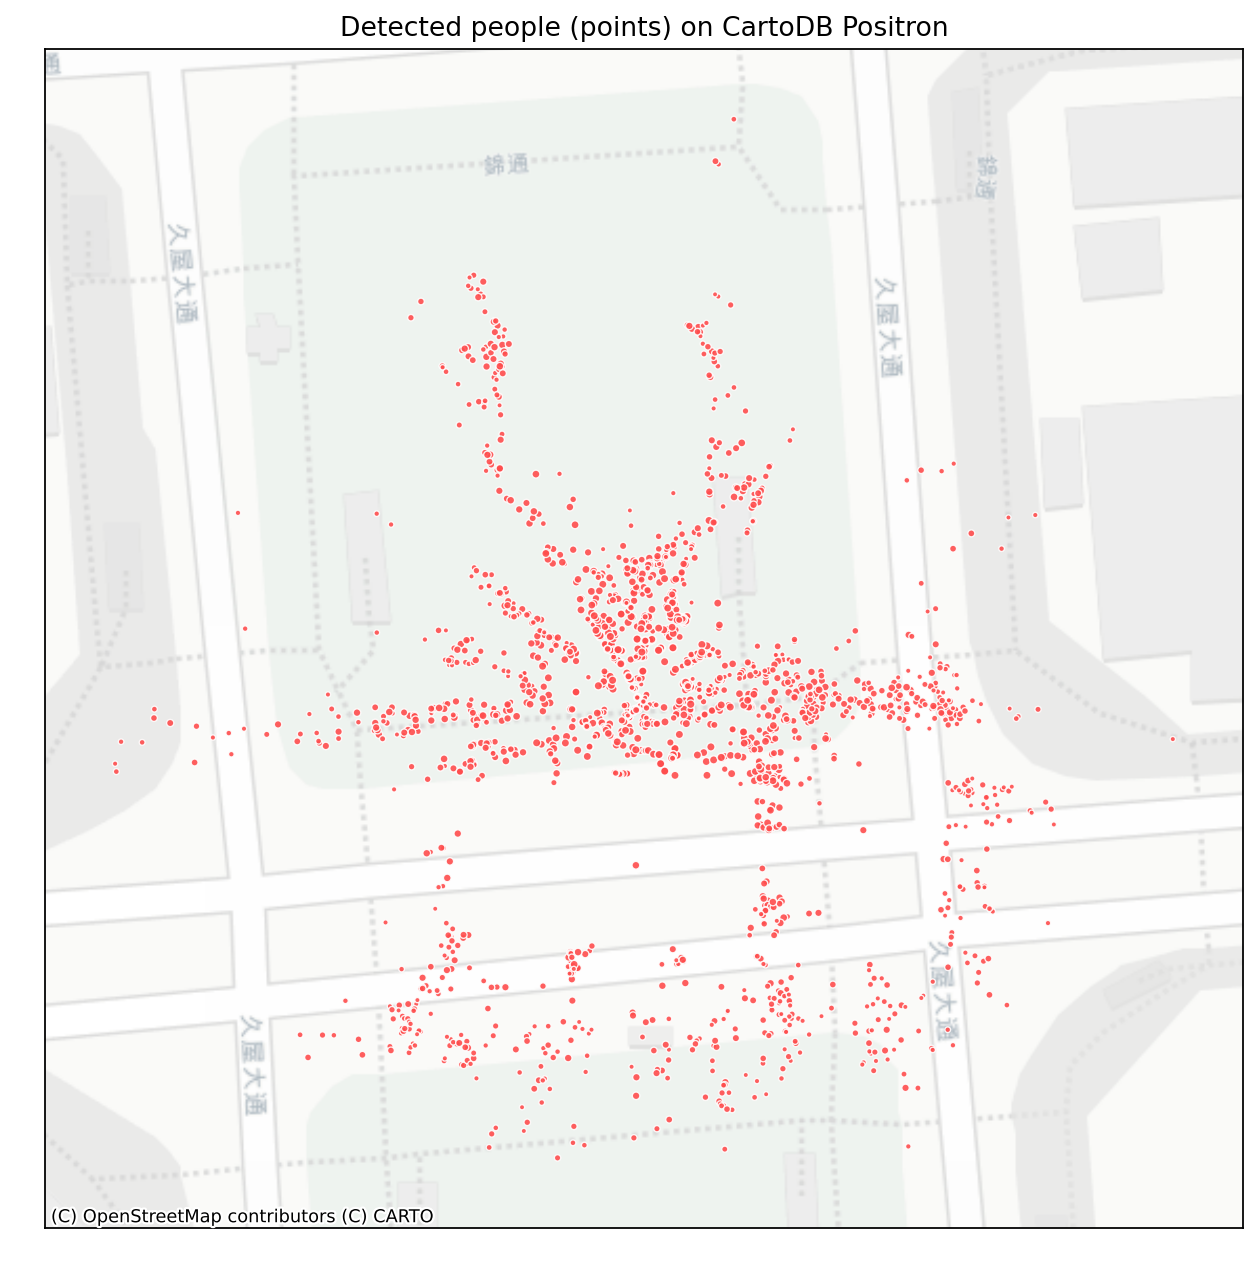

🖼️ Saved static map: /content/drive/MyDrive/Colab/360detection/output/people_points_carto.png
🌍 Saved GeoJSON: /content/drive/MyDrive/Colab/360detection/output/people_points.geojson


In [ ]:
# @title Plot all detected people as points on a Carto basemap (static PNG via contextily)

!pip -q install contextily geopandas shapely pyproj >/dev/null

import os
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt
import contextily as ctx
from google.colab import drive

# ---- Paths ----
OUTPUT_DIR = "/content/drive/MyDrive/Colab/360detection/output"
ALL_GEO_CSV = os.path.join(OUTPUT_DIR, "all_people_geo.csv")   # from previous step
POINTS_PNG  = os.path.join(OUTPUT_DIR, "people_points_carto.png")
POINTS_GEOJSON = os.path.join(OUTPUT_DIR, "people_points.geojson")

# ---- Mount Drive & load ----
drive.mount('/content/drive', force_remount=False)
assert os.path.exists(ALL_GEO_CSV), f"Not found: {ALL_GEO_CSV}"

df = pd.read_csv(ALL_GEO_CSV)
if df.empty:
    raise RuntimeError("No detections in all_people_geo.csv")

# ---- GeoDataFrame in WGS84 -> Web Mercator ----
gdf = gpd.GeoDataFrame(
    df,
    geometry=gpd.points_from_xy(df["lon"], df["lat"]),
    crs="EPSG:4326"
).to_crs(epsg=3857)  # meters, used by web tiles

# ---- Map extent (auto + small padding) ----
xmin, ymin, xmax, ymax = gdf.total_bounds
dx, dy = xmax - xmin, ymax - ymin
pad_x = max(10.0, 0.05 * dx)   # meters
pad_y = max(10.0, 0.05 * dy)   # meters
extent = (xmin - pad_x, xmax + pad_x, ymin - pad_y, ymax + pad_y)

# ---- Symbol sizes by confidence (nice-looking scaling) ----
conf = np.clip(gdf["conf"].to_numpy(dtype=float), 0.0, 1.0)
sizes = 3 + 12 * conf  # pixels^2-ish scale for matplotlib scatter

# ---- Plot ----
fig, ax = plt.subplots(figsize=(8, 8), dpi=160)
gdf.plot(ax=ax, markersize=sizes, color="#ff4d4d", edgecolor="white", linewidth=0.6, alpha=0.9)

ax.set_xlim(extent[0], extent[1])
ax.set_ylim(extent[2], extent[3])
ax.set_xticks([]); ax.set_yticks([])
ax.set_xlabel(" "); ax.set_ylabel(" ")
ax.set_title("Detected people (points) on CartoDB Positron", fontsize=12)

# Add Carto basemap
ctx.add_basemap(
    ax,
    source=ctx.providers.CartoDB.Positron,
    crs=gdf.crs.to_string()
)

plt.tight_layout()
plt.savefig(POINTS_PNG, bbox_inches="tight")
plt.show()
plt.close()
print(f"🖼️ Saved static map: {POINTS_PNG}")

# ---- Optional: export GeoJSON for GIS usage ----
gdf.to_crs(epsg=4326).to_file(POINTS_GEOJSON, driver="GeoJSON")
print(f"🌍 Saved GeoJSON: {POINTS_GEOJSON}")

In [ ]:
# @title Interactive people points on Google Satellite (Folium)
import os, pandas as pd, numpy as np
import folium
from folium import FeatureGroup
from folium.plugins import MarkerCluster
from google.colab import drive

# ---- Paths ----
OUTPUT_DIR = "/content/drive/MyDrive/Colab/360detection/output"
ALL_GEO_CSV = os.path.join(OUTPUT_DIR, "all_people_geo.csv")
OUT_HTML    = os.path.join(OUTPUT_DIR, "people_points_google.html")

# ---- Camera location (optional marker) ----
CAM_LAT = 35.169237383755025
CAM_LON = 136.90874779113642

# ---- Load data ----
drive.mount('/content/drive', force_remount=False)
assert os.path.exists(ALL_GEO_CSV), f"Not found: {ALL_GEO_CSV}"
df = pd.read_csv(ALL_GEO_CSV)
if df.empty:
    raise RuntimeError("No detections in all_people_geo.csv")

# ---- Build folium map centered at camera (zoom tweaked for street scale) ----
m = folium.Map(location=[CAM_LAT, CAM_LON], zoom_start=19, tiles=None, control_scale=True)

# ---- Google Satellite tile layer (see TOS note above) ----
google_sat = folium.TileLayer(
    tiles="https://mt1.google.com/vt/lyrs=s&x={x}&y={y}&z={z}",
    attr="Google",
    name="Google Satellite",
    overlay=False,
    control=True,
    max_zoom=21
)
google_sat.add_to(m)

# ---- Optional: add a subtle labels overlay (roads/labels); comment out if not desired ----
google_labels = folium.TileLayer(
    tiles="https://mt1.google.com/vt/lyrs=h&x={x}&y={y}&z={z}",
    attr="Google",
    name="Labels",
    overlay=True,
    control=True,
    max_zoom=21,
    opacity=0.75
)
google_labels.add_to(m)

# ---- Camera marker ----
folium.Marker(
    [CAM_LAT, CAM_LON], tooltip="Camera",
    icon=folium.Icon(color="blue", icon="camera", prefix="fa")
).add_to(m)

# ---- Plot people as CircleMarkers (small; size scaled by confidence) ----
# 10% of previous sizing → tiny points; clamp conf in [0,1]
conf = np.clip(df.get("conf", pd.Series(0.5, index=df.index)).to_numpy(float), 0.0, 1.0)
# base size (pixels) small; feel free to tweak
radii = 0.1 * (3.0 + 7.0 * conf)  # tiny circles ~0.3px to 1.0px (rendered as ~1px minimum)
# To ensure visibility on all displays, force a minimum radius of 2 px:
radii = np.maximum(radii, 2.0)

cluster = MarkerCluster(name="Detections", disableClusteringAtZoom=20)
cluster.add_to(m)

for (lat, lon, c, img, rr, rad) in zip(
        df["lat"], df["lon"], conf, df.get("image", [""]*len(df)),
        df.get("range_m", [np.nan]*len(df)), radii):
    popup_html = folium.Html(
        f"""
        <div style="font-size:12px;">
          <b>Image:</b> {img}<br/>
          <b>Confidence:</b> {c:.2f}<br/>
          <b>Range:</b> {rr:.1f} m
        </div>
        """, script=False)
    folium.CircleMarker(
        location=[float(lat), float(lon)],
        radius=float(rad),
        color="#ffffff",
        weight=0.5,
        fill=True,
        fill_color="#ff4d4d",
        fill_opacity=0.9,
        popup=folium.Popup(popup_html, max_width=220)
    ).add_to(cluster)

folium.LayerControl().add_to(m)

# ---- Save HTML ----
os.makedirs(OUTPUT_DIR, exist_ok=True)
m.save(OUT_HTML)
print(f"✅ Saved interactive map: {OUT_HTML}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Saved interactive map: /content/drive/MyDrive/Colab/360detection/output/people_points_google.html


In [ ]:
m

Output hidden; open in https://colab.research.google.com to view.